In [ ]:
#importing standard libraries
import os 
import re 
import string 
import numpy as np
import pandas as pd
from collections import Counter
#importing Text Processing Library 
import nltk 
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from textblob import TextBlob
from wordcloud import WordCloud
from gensim import utils
#import streamlit as st
import pprint
import gensim
import gensim.downloader as api
import warnings
import spacy
from spacy import displacy
from pathlib import Path
from spacy.matcher import PhraseMatcher, Matcher
from spacy.tokens import Span
import tempfile
warnings.filterwarnings(action='ignore')

# Data Visualisation 
import matplotlib.pyplot as plt 
import seaborn as sns
#import spacy_streamlit
from PIL import Image

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# Constants 
STOPWORDS = stopwords.words('english')
STOPWORDS + ['said']

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
tweets = pd.read_csv('tweets.csv')
tweets = tweets.drop(columns =['user_location'], axis = 1)
tweets.head()

,id,user_name,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1396091006030856192,Doomster,"Alt-left, liberal, pronoun:them",2009-08-23 12:22:53,309,907,8050,False,2021-05-22 13:10:08,@PrettyAmmina The change to the new blue unifo...,NaN,Twitter Web App,0.0,0.0,False
1,1395981137764397056,Unruly 🗯,I don't know what you thought this was gonna b...,2011-04-20 19:35:54,1053,523,5279,False,2021-05-22 05:53:33,I think it's now safe to say President Uhuru K...,NaN,Twitter for Android,0.0,0.0,False
2,1395433210490798082,Khavin,CCTV installation and MAINTENANCE technician. ...,2020-02-11 04:52:44,4202,3735,29563,False,2021-05-20 17:36:17,@_CrazyKenyan President Uhuru Kenyatta bribed ...,['bbinonsense'],Twitter Web App,0.0,1.0,False
3,1394739630898044931,Lecturer🇰🇪💥,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-18 19:40:15,"As @HonMoses_Kuria has just been saying,Presid...",NaN,Twitter for Android,0.0,0.0,False
4,1394561455471661057,Lecturer🇰🇪💥,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-18 07:52:15,David Murathe the KEMSA thief and President Uh...,NaN,Twitter for Android,2.0,1.0,False


In [ ]:
tweets['text'].value_counts()

@Kenyans William Ruto                                                                                                                           36
@K24Tv William Ruto                                                                                                                             28
@Kenyans William ruto                                                                                                                            9
@K24Tv William ruto                                                                                                                              7
William ruto                                                                                                                                     6
                                                                                                                                                ..
A  @StateHouseKenya Political advisor to President Uhuru Kenyatta @MutahiNgunyi HINTS that the Military will ARREST… h

In [ ]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11723 entries, 0 to 11722
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                11723 non-null  object 
 1   user_name         11723 non-null  object 
 2   user_description  10730 non-null  object 
 3   user_created      11722 non-null  object 
 4   user_followers    11722 non-null  object 
 5   user_friends      11722 non-null  object 
 6   user_favourites   11722 non-null  object 
 7   user_verified     11721 non-null  object 
 8   date              11722 non-null  object 
 9   text              11722 non-null  object 
 10  hashtags          1174 non-null   object 
 11  source            11722 non-null  object 
 12  retweets          11721 non-null  float64
 13  favorites         11721 non-null  float64
 14  is_retweet        11721 non-null  object 
dtypes: float64(2), object(13)
memory usage: 1.3+ MB


In [ ]:
tweets.describe().T

,count,mean,std,min,25%,50%,75%,max
retweets,11721.0,7.571538,60.232891,0.0,0.0,0.0,2.0,3011.0
favorites,11721.0,42.103234,317.674889,0.0,0.0,2.0,8.0,16302.0


In [ ]:
tweets.isnull().sum()

id                      0
user_name               0
user_description      993
user_created            1
user_followers          1
user_friends            1
user_favourites         1
user_verified           2
date                    1
text                    1
hashtags            10549
source                  1
retweets                2
favorites               2
is_retweet              2
dtype: int64

In [ ]:
tweets.shape

(11723, 15)

In [ ]:
#replacing the null values in 'text' column with empty strings
#replacing the null values in 'location' column with mode
tweets.fillna(value = {'text':' '},inplace = True)
tweets.isnull().sum()

id                      0
user_name               0
user_description      993
user_created            1
user_followers          1
user_friends            1
user_favourites         1
user_verified           2
date                    1
text                    0
hashtags            10549
source                  1
retweets                2
favorites               2
is_retweet              2
dtype: int64

In [ ]:
#cleaning the data
#Text cleaning function 
def clean_text(text):
    '''
        Function which returns a clean text 
    '''  
    # Lower case 
    text = text.lower()  
    # Remove numbers
    text = re.sub(r'\d','', text)
    text = re.sub(r'@[A-Za-z0-9]+','',text) #removes @mentions and substitutes with an empty string
    text = re.sub(r'@_','',text)
    text = re.sub(r'#','', text) #removes #tags
    text = re.sub(r'RT[\s]+','',text) #removes the RT
    text = re.sub(r'https?:\/\/\S+','',text)

  
    # Replace \n and \t functions 
    text = re.sub(r'\n','', text)
    text = text.strip()
    
    # Remove punctuations
    text = text.translate(str.maketrans('','', string.punctuation))
    
    # Remove Stopwords and Lemmatise the data
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text.split() if word not in STOPWORDS]
    text = ' '.join(text)
    return text

In [ ]:
tweets['text'] = tweets['text'].apply(clean_text)
tweets

,id,user_name,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1396091006030856192,Doomster,"Alt-left, liberal, pronoun:them",2009-08-23 12:22:53,309,907,8050,False,2021-05-22 13:10:08,change new blue uniform ordered president uhur...,NaN,Twitter Web App,0.0,0.0,False
1,1395981137764397056,Unruly 🗯,I don't know what you thought this was gonna b...,2011-04-20 19:35:54,1053,523,5279,False,2021-05-22 05:53:33,think safe say president uhuru kenyatta amepat...,NaN,Twitter for Android,0.0,0.0,False
2,1395433210490798082,Khavin,CCTV installation and MAINTENANCE technician. ...,2020-02-11 04:52:44,4202,3735,29563,False,2021-05-20 17:36:17,crazykenyan president uhuru kenyatta bribed mc...,['bbinonsense'],Twitter Web App,0.0,1.0,False
3,1394739630898044931,Lecturer🇰🇪💥,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-18 19:40:15,kuria sayingpresident uhuru kenyatta finish ag...,NaN,Twitter for Android,0.0,0.0,False
4,1394561455471661057,Lecturer🇰🇪💥,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-18 07:52:15,david murathe kemsa thief president uhuru keny...,NaN,Twitter for Android,2.0,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11718,1403061559727951875,Nation Africa,"We are Nation. For customer care, 📨 support@na...",2009-03-23 10:15:38,2437840,268,2352,True,2021-06-10 18:48:38,preparation top gear coronation deputy preside...,NaN,TweetDeck,11.0,102.0,False
11719,1403060195077545985,Joel Mulwa Njenga Jr 🇰🇪,Laikipia general (Hustler)\npolitics and footb...,2015-08-20 11:31:10,12398,9973,30836,False,2021-06-10 18:43:12,managed kick william ruto jubilee murathe one ...,NaN,Twitter for Android,0.0,0.0,False
11720,1403059933239721988,Mutugi,A Clone Of Socrates And Einstein.,2021-03-29 13:40:13,383,383,1596,False,2021-06-10 18:42:10,william ruto uhuru kenyatta could maintain sim...,NaN,Twitter for Android,0.0,6.0,False
11721,1403059390568087556,TV47 Kenya,"TV47 is a local, free-to-air television statio...",2015-02-13 08:17:41,29513,527,13789,False,2021-06-10 18:40:00,dp william ruto criticized proponent bbi pursu...,NaN,Twitter Web App,0.0,3.0,False


In [ ]:
TextBlob is a Sentiment Analysis can help us decipher the mood and emotions of general public and gather insightful information regarding the context

In [ ]:
#creating a function that shows subjectivity

def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

#creating a function that shows the polarity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

tweets['Subjectivity'] = tweets['text'].apply(getSubjectivity)
tweets['Polarity'] = tweets['text'].apply(getPolarity)

tweets

,id,user_name,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,Subjectivity,Polarity
0,1396091006030856192,Doomster,"Alt-left, liberal, pronoun:them",2009-08-23 12:22:53,309,907,8050,False,2021-05-22 13:10:08,change new blue uniform ordered president uhur...,NaN,Twitter Web App,0.0,0.0,False,0.277273,0.068182
1,1395981137764397056,Unruly 🗯,I don't know what you thought this was gonna b...,2011-04-20 19:35:54,1053,523,5279,False,2021-05-22 05:53:33,think safe say president uhuru kenyatta amepat...,NaN,Twitter for Android,0.0,0.0,False,0.500000,0.500000
2,1395433210490798082,Khavin,CCTV installation and MAINTENANCE technician. ...,2020-02-11 04:52:44,4202,3735,29563,False,2021-05-20 17:36:17,crazykenyan president uhuru kenyatta bribed mc...,['bbinonsense'],Twitter Web App,0.0,1.0,False,0.000000,0.000000
3,1394739630898044931,Lecturer🇰🇪💥,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-18 19:40:15,kuria sayingpresident uhuru kenyatta finish ag...,NaN,Twitter for Android,0.0,0.0,False,0.454545,0.136364
4,1394561455471661057,Lecturer🇰🇪💥,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-18 07:52:15,david murathe kemsa thief president uhuru keny...,NaN,Twitter for Android,2.0,1.0,False,0.500000,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11718,1403061559727951875,Nation Africa,"We are Nation. For customer care, 📨 support@na...",2009-03-23 10:15:38,2437840,268,2352,True,2021-06-10 18:48:38,preparation top gear coronation deputy preside...,NaN,TweetDeck,11.0,102.0,False,0.500000,0.500000
11719,1403060195077545985,Joel Mulwa Njenga Jr 🇰🇪,Laikipia general (Hustler)\npolitics and footb...,2015-08-20 11:31:10,12398,9973,30836,False,2021-06-10 18:43:12,managed kick william ruto jubilee murathe one ...,NaN,Twitter for Android,0.0,0.0,False,0.000000,0.000000
11720,1403059933239721988,Mutugi,A Clone Of Socrates And Einstein.,2021-03-29 13:40:13,383,383,1596,False,2021-06-10 18:42:10,william ruto uhuru kenyatta could maintain sim...,NaN,Twitter for Android,0.0,6.0,False,0.357143,0.000000
11721,1403059390568087556,TV47 Kenya,"TV47 is a local, free-to-air television statio...",2015-02-13 08:17:41,29513,527,13789,False,2021-06-10 18:40:00,dp william ruto criticized proponent bbi pursu...,NaN,Twitter Web App,0.0,3.0,False,0.100000,0.000000


In [ ]:
#function that computes the negative/positive/neutral sentiments

def getScore(score):
    if score <0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else: 
        return 'positive'
tweets['Analysis'] = tweets['Polarity'].apply(getScore)
tweets

,id,user_name,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,Subjectivity,Polarity,Analysis
0,1396091006030856192,Doomster,"Alt-left, liberal, pronoun:them",2009-08-23 12:22:53,309,907,8050,False,2021-05-22 13:10:08,change new blue uniform ordered president uhur...,NaN,Twitter Web App,0.0,0.0,False,0.277273,0.068182,positive
1,1395981137764397056,Unruly 🗯,I don't know what you thought this was gonna b...,2011-04-20 19:35:54,1053,523,5279,False,2021-05-22 05:53:33,think safe say president uhuru kenyatta amepat...,NaN,Twitter for Android,0.0,0.0,False,0.500000,0.500000,positive
2,1395433210490798082,Khavin,CCTV installation and MAINTENANCE technician. ...,2020-02-11 04:52:44,4202,3735,29563,False,2021-05-20 17:36:17,crazykenyan president uhuru kenyatta bribed mc...,['bbinonsense'],Twitter Web App,0.0,1.0,False,0.000000,0.000000,neutral
3,1394739630898044931,Lecturer🇰🇪💥,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-18 19:40:15,kuria sayingpresident uhuru kenyatta finish ag...,NaN,Twitter for Android,0.0,0.0,False,0.454545,0.136364,positive
4,1394561455471661057,Lecturer🇰🇪💥,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-18 07:52:15,david murathe kemsa thief president uhuru keny...,NaN,Twitter for Android,2.0,1.0,False,0.500000,0.200000,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11718,1403061559727951875,Nation Africa,"We are Nation. For customer care, 📨 support@na...",2009-03-23 10:15:38,2437840,268,2352,True,2021-06-10 18:48:38,preparation top gear coronation deputy preside...,NaN,TweetDeck,11.0,102.0,False,0.500000,0.500000,positive
11719,1403060195077545985,Joel Mulwa Njenga Jr 🇰🇪,Laikipia general (Hustler)\npolitics and footb...,2015-08-20 11:31:10,12398,9973,30836,False,2021-06-10 18:43:12,managed kick william ruto jubilee murathe one ...,NaN,Twitter for Android,0.0,0.0,False,0.000000,0.000000,neutral
11720,1403059933239721988,Mutugi,A Clone Of Socrates And Einstein.,2021-03-29 13:40:13,383,383,1596,False,2021-06-10 18:42:10,william ruto uhuru kenyatta could maintain sim...,NaN,Twitter for Android,0.0,6.0,False,0.357143,0.000000,neutral
11721,1403059390568087556,TV47 Kenya,"TV47 is a local, free-to-air television statio...",2015-02-13 08:17:41,29513,527,13789,False,2021-06-10 18:40:00,dp william ruto criticized proponent bbi pursu...,NaN,Twitter Web App,0.0,3.0,False,0.100000,0.000000,neutral


In [ ]:
#summary
tb_counts = tweets.Analysis.value_counts()

tb_counts

neutral     6810
positive    3392
negative    1521
Name: Analysis, dtype: int64

In [ ]:
Using Vader Analysis 
VADER ( Valence Aware Dictionary for Sentiment Reasoning) is a model used for text sentiment analysis that is sensitive to both polarity

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
pip install vader-sentiment

     |████████████████████████████████| 132 kB 8.4 MB/s 


In [ ]:
pip install vaderSentiment

     |████████████████████████████████| 125 kB 8.4 MB/s 


In [ ]:
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
# function to calculate vader sentiment
def vadersentimentanalysis(text):
    vs = analyzer.polarity_scores(text)
    return vs['compound']
tweets['Vader Sentiment'] = tweets['Analysis'].apply(vadersentimentanalysis)



# function to analyse
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound <= -0.5 :
        return 'Negative'
    else:
      return 'Neutral'
tweets['Vader_Analysis'] = tweets['Vader Sentiment'].apply(getScore)
tweets

,id,user_name,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,Subjectivity,Polarity,Analysis,Vader Sentiment,Vader_Analysis
0,1396091006030856192,Doomster,"Alt-left, liberal, pronoun:them",2009-08-23 12:22:53,309,907,8050,False,2021-05-22 13:10:08,change new blue uniform ordered president uhur...,NaN,Twitter Web App,0.0,0.0,False,0.277273,0.068182,positive,0.5574,positive
1,1395981137764397056,Unruly 🗯,I don't know what you thought this was gonna b...,2011-04-20 19:35:54,1053,523,5279,False,2021-05-22 05:53:33,think safe say president uhuru kenyatta amepat...,NaN,Twitter for Android,0.0,0.0,False,0.500000,0.500000,positive,0.5574,positive
2,1395433210490798082,Khavin,CCTV installation and MAINTENANCE technician. ...,2020-02-11 04:52:44,4202,3735,29563,False,2021-05-20 17:36:17,crazykenyan president uhuru kenyatta bribed mc...,['bbinonsense'],Twitter Web App,0.0,1.0,False,0.000000,0.000000,neutral,0.0000,neutral
3,1394739630898044931,Lecturer🇰🇪💥,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-18 19:40:15,kuria sayingpresident uhuru kenyatta finish ag...,NaN,Twitter for Android,0.0,0.0,False,0.454545,0.136364,positive,0.5574,positive
4,1394561455471661057,Lecturer🇰🇪💥,President Kenyatta's critic.William Samoei Rut...,2020-01-23 19:10:51,774,1467,4150,False,2021-05-18 07:52:15,david murathe kemsa thief president uhuru keny...,NaN,Twitter for Android,2.0,1.0,False,0.500000,0.200000,positive,0.5574,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11718,1403061559727951875,Nation Africa,"We are Nation. For customer care, 📨 support@na...",2009-03-23 10:15:38,2437840,268,2352,True,2021-06-10 18:48:38,preparation top gear coronation deputy preside...,NaN,TweetDeck,11.0,102.0,False,0.500000,0.500000,positive,0.5574,positive
11719,1403060195077545985,Joel Mulwa Njenga Jr 🇰🇪,Laikipia general (Hustler)\npolitics and footb...,2015-08-20 11:31:10,12398,9973,30836,False,2021-06-10 18:43:12,managed kick william ruto jubilee murathe one ...,NaN,Twitter for Android,0.0,0.0,False,0.000000,0.000000,neutral,0.0000,neutral
11720,1403059933239721988,Mutugi,A Clone Of Socrates And Einstein.,2021-03-29 13:40:13,383,383,1596,False,2021-06-10 18:42:10,william ruto uhuru kenyatta could maintain sim...,NaN,Twitter for Android,0.0,6.0,False,0.357143,0.000000,neutral,0.0000,neutral
11721,1403059390568087556,TV47 Kenya,"TV47 is a local, free-to-air television statio...",2015-02-13 08:17:41,29513,527,13789,False,2021-06-10 18:40:00,dp william ruto criticized proponent bbi pursu...,NaN,Twitter Web App,0.0,3.0,False,0.100000,0.000000,neutral,0.0000,neutral


In [ ]:
#summary
tb_counts = tweets.Vader_Analysis.value_counts()

tb_counts

neutral     6810
positive    3392
negative    1521
Name: Vader_Analysis, dtype: int64

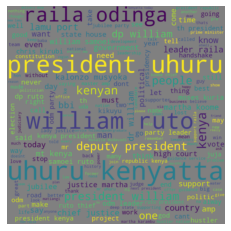

In [ ]:
#creating a word cloud
import matplotlib.pyplot as plt
all_words = ' '.join(twts for twts in tweets['text'])
wordcloud = WordCloud( width = 1000, height = 1000, random_state = 21, max_font_size = 120 , background_color= 'gray').generate(all_words)

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()